Fetching data for Macro DCA Buy-and-Rest Strategy on QQQ...
Data Cleaning Complete. Total Months to Process: 282 months.
Running simulation with complex rest period rules...
Simulation Complete (2002-03-01 to 2025-08-01)
Asset Used: QQQ (Nasdaq 100 ETF)
Actual Months Processed: 282
------------------------------------------------------------
TOTAL MACRO DCA BUY EVENTS: 9
LAST MACRO DCA BUY EVENT: 2024-09-01
------------------------------------------------------------
CAPITAL DEPLOYMENT SUMMARY
------------------------------------------------------------
Total Committed Capital (Macro C / Return Base): $28,200.00
Total Committed Capital (Vanilla Base):           $28,200.00
Total Macro Deployed Capital (D):                 $28,200.00
Macro Strategy Cash in Bank (B):                  $0.00
VERIFICATION: C = D + B? True (C = 28,200.00, D+B = 28,200.00)
------------------------------------------------------------
PERFORMANCE COMPARISON
-------------------------------------------------------

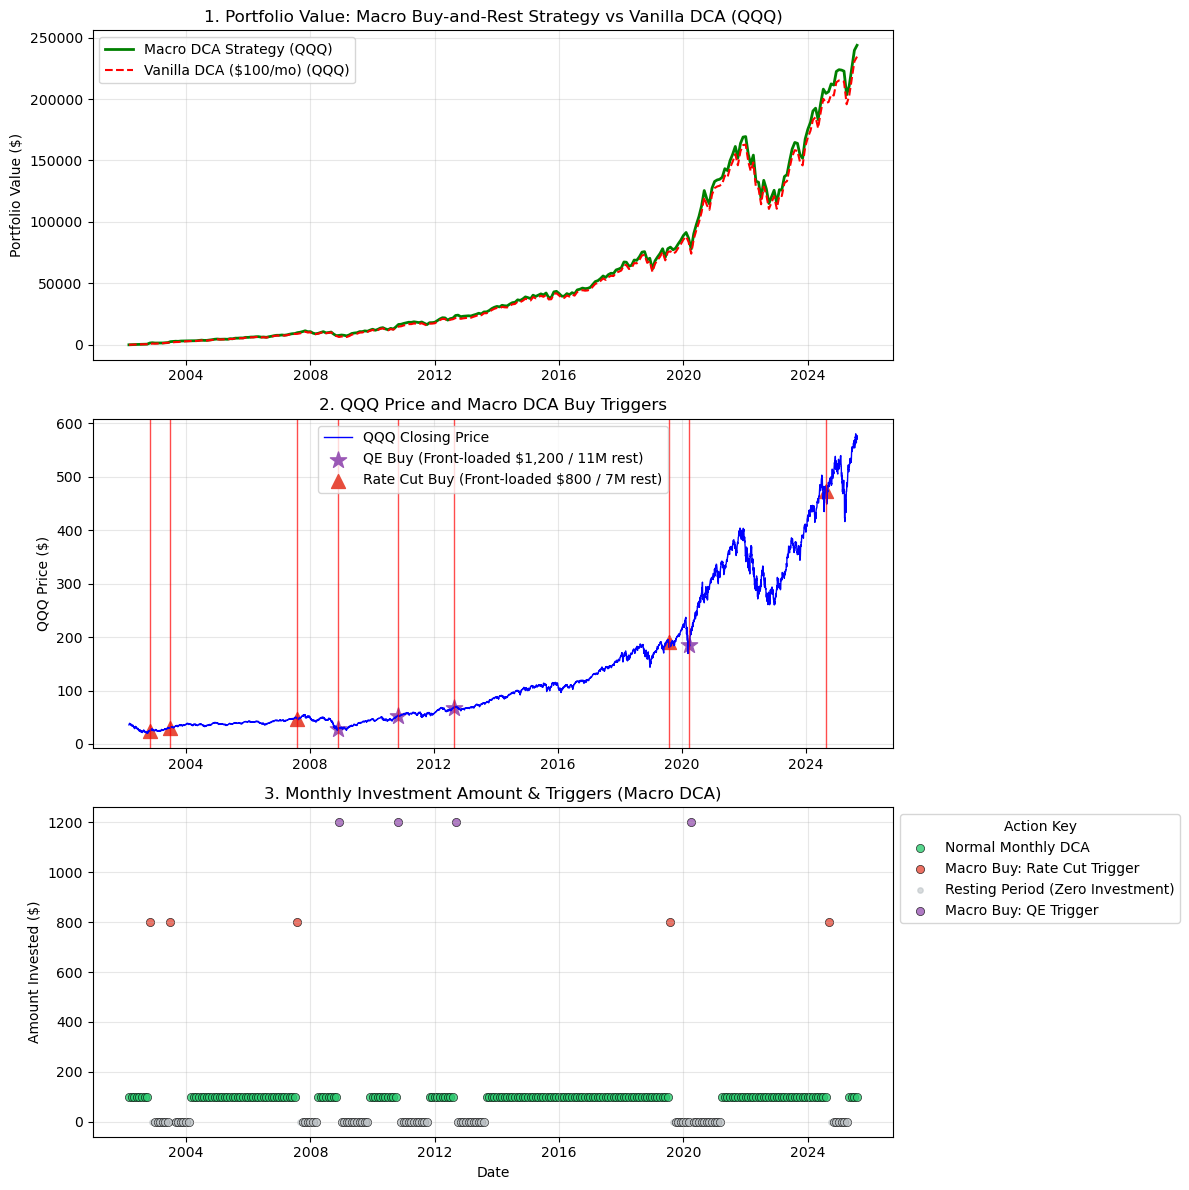

In [17]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys

# Target Asset: Nasdaq 100 ETF (QQQ)
ASSET_TICKER = 'QQQ'
MONTHLY_BASE = 100

# Strategy Parameters (Months to skip AFTER the front-loaded buy month)
# 1. Rate Cut: $800 total commitment ($100 base + $700 advance)
REST_PERIOD_RATE_CUT = 7
FRONT_LOAD_RATE_CUT = MONTHLY_BASE * (REST_PERIOD_RATE_CUT + 1) # $800
# 2. QE: $1200 total commitment ($100 base + $1100 advance)
REST_PERIOD_QE = 11
FRONT_LOAD_QE = MONTHLY_BASE * (REST_PERIOD_QE + 1) # $1200

# ==========================================
# 1. DATA FETCHING
# ==========================================
print(f"Fetching data for Macro DCA Buy-and-Rest Strategy on {ASSET_TICKER}...")

# --- USER ADJUSTABLE DATES (Set to long historical range for full backtest) ---
start_date = '2002-03-01' 
end_date = '2025-09-01'
# -----------------------------

# Fetch QQQ Data (Nasdaq 100 ETF)
try:
    asset_data = yf.download(ASSET_TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)
except Exception as e:
    print(f"FATAL ERROR: Failed to download {ASSET_TICKER} data: {e}")
    sys.exit(1)

# --- Ensure correct column structure ---
if isinstance(asset_data.columns, pd.MultiIndex):
    asset_data.columns = asset_data.columns.get_level_values(0)

# Resample to Monthly Start (MS) and take the Open price (buying on day 1)
asset_monthly = asset_data['Open'].resample('MS').first().to_frame(name='Price')

# Fetch Macro Data from FRED (Federal Reserve Economic Data)
try:
    # FEDFUNDS: Effective Federal Funds Rate (Monthly)
    # USREC: NBER based Recession Indicators (Monthly)
    macro_data = web.DataReader(['FEDFUNDS', 'USREC'], 'fred', start_date, end_date)
except Exception as e:
    print(f"Error fetching FRED data: {e}. Check internet connection or FRED API access.")
    raise

# Merge Data and clean up
df = asset_monthly.join(macro_data, how='left')
df = df.dropna()

print(f"Data Cleaning Complete. Total Months to Process: {len(df)} months.")

# ==========================================
# 2. DEFINE QE DATES AND TRIGGERS
# ==========================================
# These dates represent the first month following a major QE announcement
qe_announcements = [
    '2008-12-01', # QE1
    '2010-11-01', # QE2
    '2012-09-01', # QE3
    '2020-04-01', # QE4 (Covid)
]
qe_dates = pd.to_datetime(qe_announcements)

# ==========================================
# 3. STRATEGY SIMULATION
# ==========================================

shares_owned = 0
last_dump_date = "N/A"
dump_count = 0 

# Total Committed Capital (C): Tracks the $100/month baseline plus any lump sum additions
total_committed_capital = 0 
# Deployed Capital (D): Total money physically spent on shares
deployed_capital_macro = 0 

# State variables
# Tracks the remaining months of rest (set to 7 or 11 after a dump event)
qe_pause_counter = 0 
# Tracks which type of event initiated the current pause
current_pause_type = "None" 

# Vanilla Comparison
vanilla_shares = 0
vanilla_invested = 0 

history = []

# Initialize prev_rate after dropna()
prev_rate = df['FEDFUNDS'].iloc[0]

print("Running simulation with complex rest period rules...")

for date, row in df.iterrows():
    price = row['Price']
    rate = row['FEDFUNDS']
    
    is_recession_official = int(row['USREC']) == 1
    rate_delta = rate - prev_rate
    
    is_qe = date in qe_dates
    # A rate cut is defined as a significant drop (> 5 basis points)
    is_cut = rate_delta < -0.05
    is_cut_without_recession = is_cut and not is_recession_official
    
    investment_amount = 0
    action = ""
    
    # --- 1. RESTING PERIOD OVERRIDE (Highest Priority) ---
    if qe_pause_counter > 0:
        # If we are resting, the Macro strategy does NOTHING and ignores new triggers.
        action = f"Resting Period ({current_pause_type}) - Month Skipped (Remaining: {qe_pause_counter})"
        investment_amount = 0 
        
        # This is the ONLY operation for the Macro Strategy during rest
        qe_pause_counter -= 1 
        if qe_pause_counter == 0:
            current_pause_type = "None" # Reset pause type when resting ends
        
        # --- Vanilla DCA continues uninterrupted ---
        vanilla_investment_amount = MONTHLY_BASE
        vanilla_shares_bought = MONTHLY_BASE / price
        vanilla_invested += vanilla_investment_amount 
        vanilla_shares += vanilla_shares_bought
        
        macro_shares_bought = 0
        prev_rate = rate
        
        history.append({
            'Date': date, 'Price': price, 'Action': action, 
            'Macro_Invested': 0, 
            'Macro_Shares_Bought': macro_shares_bought, 
            'Macro_Cumulative_Shares': shares_owned, 
            'Vanilla_Invested': vanilla_investment_amount, 
            'Vanilla_Shares_Bought': vanilla_shares_bought, 
            'Vanilla_Cumulative_Shares': vanilla_shares, 
            'Vanilla_Committed_Capital': vanilla_invested, 
            'Bank_Balance': 0, # Bank balance will be calculated post-loop
            'Portfolio_Value': shares_owned * price,
            'Vanilla_Value': vanilla_shares * price, 
            'Deployed_Capital_Macro': deployed_capital_macro,
            'Total_Committed_Capital': total_committed_capital, 
            'Last_Dump': last_dump_date,
            'Dump_Count': dump_count,
        })
        continue 
    
    # --- 2. NO REST: CHECK FOR NEW TRIGGERS ---
    
    # QE Trigger (Highest priority trigger)
    if is_qe:
        
        action = f"Macro Buy: QE Trigger (Front-loaded ${FRONT_LOAD_QE:,.0f} / {REST_PERIOD_QE}M rest)" 
        investment_amount = FRONT_LOAD_QE
        
        # Set pause counter and type
        qe_pause_counter = REST_PERIOD_QE
        current_pause_type = "QE"
        
        last_dump_date = date.strftime('%Y-%m-%d')
        dump_count += 1 
        
        # --- CAPITAL COMMITMENT ADJUSTMENT ---
        total_committed_capital += FRONT_LOAD_QE 
        
    # Rate Cut Trigger (Second priority trigger)
    elif is_cut_without_recession:
            
        action = f"Macro Buy: Rate Cut Trigger (Front-loaded ${FRONT_LOAD_RATE_CUT:,.0f} / {REST_PERIOD_RATE_CUT}M rest)"
        investment_amount = FRONT_LOAD_RATE_CUT
        
        # Set pause counter and type
        qe_pause_counter = REST_PERIOD_RATE_CUT
        current_pause_type = "Rate Cut"
        
        last_dump_date = date.strftime('%Y-%m-%d')
        dump_count += 1 
        
        # --- CAPITAL COMMITMENT ADJUSTMENT ---
        total_committed_capital += FRONT_LOAD_RATE_CUT
        
    # --- 3. NORMAL TRADING (Default) ---
    else:
        # Rule: No trigger, no rest period -> $100
        action = "Normal Monthly DCA"
        investment_amount = MONTHLY_BASE
        
        # --- CAPITAL COMMITMENT (Normal $100/mo) ---
        total_committed_capital += MONTHLY_BASE


    # --- EXECUTE TRADE (Normal & Buy Cases for Macro) ---
    macro_shares_bought = investment_amount / price
    shares_owned += macro_shares_bought
    deployed_capital_macro += investment_amount
    
    # --- EXECUTE TRADE (Vanilla DCA always invests $100) ---
    vanilla_investment_amount = MONTHLY_BASE
    vanilla_shares_bought = vanilla_investment_amount / price
    vanilla_shares += vanilla_shares_bought 
    vanilla_invested += MONTHLY_BASE # Vanilla base grows by $100 every month

    prev_rate = rate
    
    history.append({
        'Date': date, 'Price': price, 'Action': action, 
        'Macro_Invested': investment_amount, 
        'Macro_Shares_Bought': macro_shares_bought, 
        'Macro_Cumulative_Shares': shares_owned, 
        'Vanilla_Invested': vanilla_investment_amount, 
        'Vanilla_Shares_Bought': vanilla_shares_bought, 
        'Vanilla_Cumulative_Shares': vanilla_shares, 
        'Vanilla_Committed_Capital': vanilla_invested, 
        'Bank_Balance': 0, 
        'Portfolio_Value': shares_owned * price,
        'Vanilla_Value': vanilla_shares * price, 
        'Deployed_Capital_Macro': deployed_capital_macro,
        'Total_Committed_Capital': total_committed_capital,
        'Last_Dump': last_dump_date,
        'Dump_Count': dump_count,
    })

# Create Results DataFrame
results = pd.DataFrame(history).set_index('Date')

# ==========================================
# 4. ANALYSIS & PLOTTING
# ==========================================

# Final Accounting
final_committed_macro = results['Total_Committed_Capital'].iloc[-1]
final_committed_vanilla = results['Vanilla_Committed_Capital'].iloc[-1] 
final_deployed_macro = results['Deployed_Capital_Macro'].iloc[-1]

# Calculate final bank balance (B): reflects unspent commitment if simulation ends mid-rest.
final_bank_balance = final_committed_macro - final_deployed_macro
results.loc[results.index[-1], 'Bank_Balance'] = final_bank_balance

final_macro_val = results['Portfolio_Value'].iloc[-1]
final_vanilla_val = results['Vanilla_Value'].iloc[-1]
final_dump_count = results['Dump_Count'].iloc[-1]

print(f"Simulation Complete ({results.index[0].date()} to {results.index[-1].date()})")
print(f"Asset Used: {ASSET_TICKER} (Nasdaq 100 ETF)")
print(f"Actual Months Processed: {len(results)}")
print("-" * 60)
print(f"TOTAL MACRO DCA BUY EVENTS: {final_dump_count}")
print(f"LAST MACRO DCA BUY EVENT: {results['Last_Dump'].iloc[-1]}")
print("-" * 60)

print("CAPITAL DEPLOYMENT SUMMARY")
print("-" * 60)
# Macro Committed Capital (C)
print(f"Total Committed Capital (Macro C / Return Base): ${final_committed_macro:,.2f}") 
# Vanilla Committed Capital (V)
print(f"Total Committed Capital (Vanilla Base):           ${final_committed_vanilla:,.2f}") 
print(f"Total Macro Deployed Capital (D):                 ${final_deployed_macro:,.2f}")
print(f"Macro Strategy Cash in Bank (B):                  ${final_bank_balance:,.2f}")

# Verification: C = D + B should now be true by definition
c_d_b_check = final_deployed_macro + final_bank_balance
print(f"VERIFICATION: C = D + B? {abs(c_d_b_check - final_committed_macro) < 0.01} (C = {final_committed_macro:,.2f}, D+B = {c_d_b_check:,.2f})")
print("-" * 60)

print("PERFORMANCE COMPARISON")
print("-" * 60)

# Macro DCA uses Macro C as the return base
print(f"Strategy: Macro DCA Buy-and-Rest on {ASSET_TICKER}")
print(f"Capital Base:    ${final_committed_macro:,.2f}")
print(f"Final Value:     ${final_macro_val:,.2f}")
print(f"Total Return:    {((final_macro_val - final_committed_macro)/final_committed_macro)*100:.2f}%") 
print("-" * 60)

# Vanilla DCA uses Vanilla Committed Capital as the return base
print(f"Strategy: Vanilla DCA (${MONTHLY_BASE}/mo) on {ASSET_TICKER}")
print(f"Capital Base:    ${final_committed_vanilla:,.2f}")
print(f"Final Value:     ${final_vanilla_val:,.2f}")
print(f"Total Return:    {((final_vanilla_val - final_committed_vanilla)/final_committed_vanilla)*100:.2f}%")

# ==========================================
# TRADE HISTORY DISPLAY (FULL ENTRIES)
# ==========================================
print("-" * 60)
print("FULL TRADE HISTORY (Macro vs. Vanilla) - Last 20 Entries")
print("-" * 60)

# Function to format the trade history output
def format_trade_history(df):
    formatted_df = df.copy()
    formatted_df.index = formatted_df.index.strftime('%Y-%m-%d')
    
    # Format numeric columns for display
    for col in ['Price']:
        formatted_df[col] = formatted_df[col].map('${:,.2f}'.format)
        
    # Format Capital and Investment columns
    for col in ['Macro_Invested', 'Vanilla_Invested', 'Bank_Balance', 'Total_Committed_Capital', 'Vanilla_Committed_Capital', 'Deployed_Capital_Macro']:
        formatted_df[col] = formatted_df[col].map('${:,.2f}'.format)
        
    for col in ['Macro_Shares_Bought', 'Vanilla_Shares_Bought', 'Macro_Cumulative_Shares', 'Vanilla_Cumulative_Shares']:
        # Only apply thousand separators for share counts
        formatted_df[col] = formatted_df[col].map('{:,.4f}'.format)
        
    formatted_df.index.name = 'Date'
    return formatted_df

# Create a clean trade history DataFrame including Bank Balance for context
trade_history_cols = [
    'Price', 'Action', 'Bank_Balance',
    'Total_Committed_Capital',        # Macro C
    'Vanilla_Committed_Capital',      # Vanilla C
    'Deployed_Capital_Macro',
    'Macro_Invested', 'Macro_Shares_Bought', 'Macro_Cumulative_Shares', 
    'Vanilla_Invested', 'Vanilla_Shares_Bought', 'Vanilla_Cumulative_Shares'
]
trade_history = results[trade_history_cols]

formatted_history = format_trade_history(trade_history)

# Display the last 20 entries
print(formatted_history.tail(20).to_string())

print("-" * 60)


# ==========================================
# PLOTTING
# ==========================================
plt.figure(figsize=(12, 12))

# Plot 1: Portfolio Comparison
plt.subplot(3, 1, 1)
plt.plot(results.index, results['Portfolio_Value'], label=f'Macro DCA Strategy ({ASSET_TICKER})', color='green', linewidth=2)
plt.plot(results.index, results['Vanilla_Value'], label=f'Vanilla DCA (${MONTHLY_BASE}/mo) ({ASSET_TICKER})', color='red', linestyle='--', linewidth=1.5)
plt.title(f'1. Portfolio Value: Macro Buy-and-Rest Strategy vs Vanilla DCA ({ASSET_TICKER})')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: QQQ Price with Major Buy Events
plt.subplot(3, 1, 2)
# Use the full price series for a smooth line
plt.plot(asset_data['Close'], label=f'{ASSET_TICKER} Closing Price', color='blue', linewidth=1)

# Highlight buy events on the price chart
buy_dates = results[results['Action'].str.contains('Macro Buy:')].index
for date in buy_dates:
    plt.axvline(date, color='red', linestyle='-', linewidth=1, alpha=0.7)
    
# Plot different markers for different types of buys
qe_buys = results[results['Action'].str.contains('QE Trigger')].index
rate_cut_buys = results[results['Action'].str.contains('Rate Cut Trigger')].index

plt.scatter(qe_buys, results.loc[qe_buys, 'Price'], color='#9B59B6', marker='*', s=150, label=f'QE Buy (Front-loaded ${FRONT_LOAD_QE:,.0f} / 11M rest)')
plt.scatter(rate_cut_buys, results.loc[rate_cut_buys, 'Price'], color='#E74C3C', marker='^', s=100, label=f'Rate Cut Buy (Front-loaded ${FRONT_LOAD_RATE_CUT:,.0f} / 7M rest)')


plt.title(f'2. {ASSET_TICKER} Price and Macro DCA Buy Triggers')
plt.ylabel(f'{ASSET_TICKER} Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)


# Plot 3: Monthly Investment Amount & Triggers
plt.subplot(3, 1, 3)

colors = {
    'Macro Buy: QE Trigger': '#9B59B6', 
    'Macro Buy: Rate Cut Trigger': '#E74C3C', 
    'Normal Monthly DCA': '#2ECC71', 
    'Resting Period': '#BDC3C7' 
}
actions_to_plot = results['Action'].unique()

legend_labels = set()
for action in actions_to_plot:
    
    if 'QE Trigger' in action:
        key = 'Macro Buy: QE Trigger'
    elif 'Rate Cut Trigger' in action:
        key = 'Macro Buy: Rate Cut Trigger'
    elif 'Resting Period' in action:
        key = 'Resting Period'
    else:
        key = 'Normal Monthly DCA'
        
    color = colors.get(key, 'black')
    
    subset = results[results['Action'] == action]
    if not subset.empty:
        y_data = subset['Macro_Invested']
        
        label_to_use = key
        
        # Only add a label once for each key type
        if label_to_use not in legend_labels:
            
            # Special case for resting period label to show the zero amount
            if key == 'Resting Period':
                 plt.scatter(subset.index, y_data, label=f'{label_to_use} (Zero Investment)', color=color, s=15, alpha=0.6)
            else:
                 # Ensure we only plot the specific type of buy action once for the legend
                 if key not in plt.gca().get_legend_handles_labels()[1]:
                    plt.scatter(subset.index, y_data, label=action.split('(')[0].strip(), color=color, s=35, alpha=0.8, edgecolors='black', linewidth=0.5)
            
            legend_labels.add(label_to_use)
        else:
            plt.scatter(subset.index, y_data, color=color, s=35, alpha=0.8, edgecolors='black', linewidth=0.5)


plt.title('3. Monthly Investment Amount & Triggers (Macro DCA)')
plt.xlabel('Date')
plt.ylabel('Amount Invested ($)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Action Key")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Fetching data for Macro DCA Buy-and-Rest Strategy on NQ=F...
Data Cleaning Complete. Total Months to Process: 48 months.
Running simulation with complex rest period rules...
Simulation Complete (2018-01-01 to 2021-12-01)
Asset Used: NQ=F (Nasdaq 100 Futures)
Actual Months Processed: 48
------------------------------------------------------------
TOTAL MACRO DCA BUY EVENTS: 2
LAST MACRO DCA BUY EVENT: 2020-04-01
------------------------------------------------------------
CAPITAL DEPLOYMENT SUMMARY
------------------------------------------------------------
Total Committed Capital (Macro C / Return Base): $4,800.00
Total Committed Capital (Vanilla Base):           $4,800.00
Total Macro Deployed Capital (D):                 $4,800.00
Macro Strategy Cash in Bank (B):                  $0.00
VERIFICATION: C = D + B? True (C = 4,800.00, D+B = 4,800.00)
------------------------------------------------------------
PERFORMANCE COMPARISON
--------------------------------------------------------

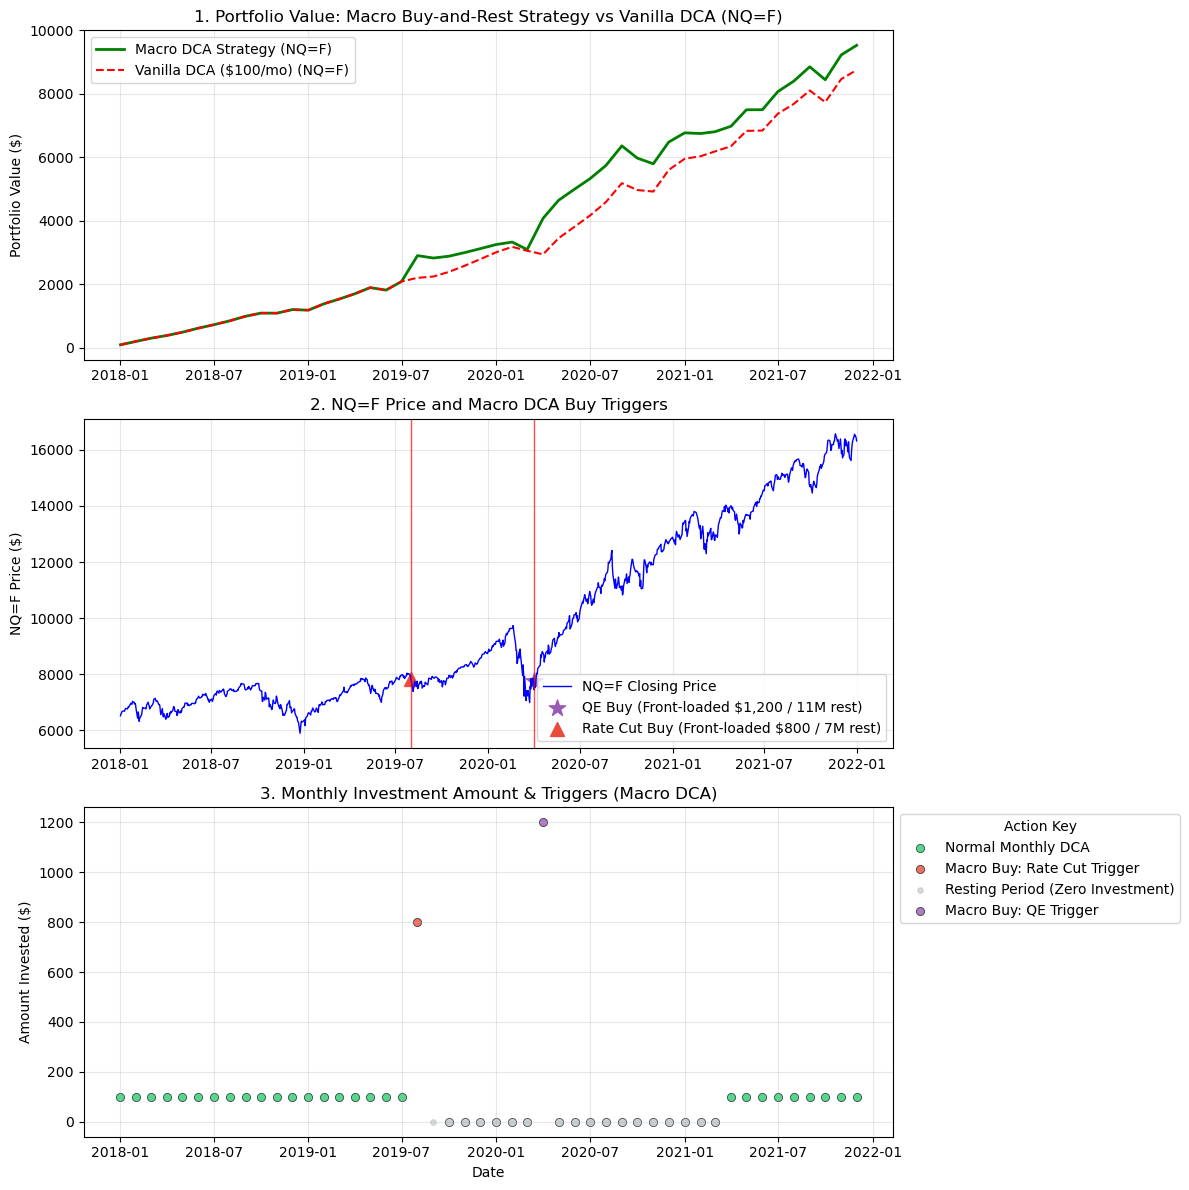

In [22]:
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import sys

# Target Asset: Nasdaq 100 Futures (NQ=F)
# Note: Futures prices can be significantly different from the QQQ ETF price, 
# but the relative performance and signals remain valid for backtesting the strategy.
ASSET_TICKER = 'NQ=F'
MONTHLY_BASE = 100

# Strategy Parameters (Months to skip AFTER the front-loaded buy month)
# 1. Rate Cut: $800 total commitment ($100 base + $700 advance)
REST_PERIOD_RATE_CUT = 7
FRONT_LOAD_RATE_CUT = MONTHLY_BASE * (REST_PERIOD_RATE_CUT + 1) # $800
# 2. QE: $1200 total commitment ($100 base + $1100 advance)
REST_PERIOD_QE = 11
FRONT_LOAD_QE = MONTHLY_BASE * (REST_PERIOD_QE + 1) # $1200

# ==========================================
# 1. DATA FETCHING
# ==========================================
print(f"Fetching data for Macro DCA Buy-and-Rest Strategy on {ASSET_TICKER}...")

# --- USER ADJUSTABLE DATES (Set to long historical range for full backtest) ---
start_date = '2018-01-01' 
end_date = '2022-01-01'
# -----------------------------

# Fetch NQ=F Data (Nasdaq 100 Futures)
try:
    # auto_adjust=False is standard for futures/indices
    asset_data = yf.download(ASSET_TICKER, start=start_date, end=end_date, progress=False, auto_adjust=False)
except Exception as e:
    print(f"FATAL ERROR: Failed to download {ASSET_TICKER} data: {e}")
    sys.exit(1)

# --- Ensure correct column structure ---
if isinstance(asset_data.columns, pd.MultiIndex):
    asset_data.columns = asset_data.columns.get_level_values(0)

# Resample to Monthly Start (MS) and take the Open price (buying on day 1)
asset_monthly = asset_data['Open'].resample('MS').first().to_frame(name='Price')

# Fetch Macro Data from FRED (Federal Reserve Economic Data)
try:
    # FEDFUNDS: Effective Federal Funds Rate (Monthly)
    # USREC: NBER based Recession Indicators (Monthly)
    macro_data = web.DataReader(['FEDFUNDS', 'USREC'], 'fred', start_date, end_date)
except Exception as e:
    print(f"Error fetching FRED data: {e}. Check internet connection or FRED API access.")
    raise

# Merge Data and clean up
df = asset_monthly.join(macro_data, how='left')
df = df.dropna()

print(f"Data Cleaning Complete. Total Months to Process: {len(df)} months.")

# ==========================================
# 2. DEFINE QE DATES AND TRIGGERS
# ==========================================
# These dates represent the first month following a major QE announcement
qe_announcements = [
    '2008-12-01', # QE1
    '2010-11-01', # QE2
    '2012-09-01', # QE3
    '2020-04-01', # QE4 (Covid)
]
qe_dates = pd.to_datetime(qe_announcements)

# ==========================================
# 3. STRATEGY SIMULATION
# ==========================================

shares_owned = 0
last_dump_date = "N/A"
dump_count = 0 

# Total Committed Capital (C): Tracks the $100/month baseline plus any lump sum additions
total_committed_capital = 0 
# Deployed Capital (D): Total money physically spent on shares
deployed_capital_macro = 0 

# State variables
# Tracks the remaining months of rest (set to 7 or 11 after a dump event)
qe_pause_counter = 0 
# Tracks which type of event initiated the current pause
current_pause_type = "None" 

# Vanilla Comparison
vanilla_shares = 0
vanilla_invested = 0 

history = []

# Initialize prev_rate after dropna()
prev_rate = df['FEDFUNDS'].iloc[0]

print("Running simulation with complex rest period rules...")

for date, row in df.iterrows():
    price = row['Price']
    rate = row['FEDFUNDS']
    
    is_recession_official = int(row['USREC']) == 1
    # Calculate rate change from the previous month
    rate_delta = rate - prev_rate
    
    is_qe = date in qe_dates
    # A rate cut is defined as a significant drop (> 5 basis points)
    is_cut = rate_delta < -0.05
    is_cut_without_recession = is_cut and not is_recession_official
    
    investment_amount = 0
    action = ""
    
    # --- 1. RESTING PERIOD OVERRIDE (Highest Priority) ---
    if qe_pause_counter > 0:
        # If we are resting, the Macro strategy does NOTHING and ignores new triggers.
        action = f"Resting Period ({current_pause_type}) - Month Skipped (Remaining: {qe_pause_counter})"
        investment_amount = 0 
        
        # This is the ONLY operation for the Macro Strategy during rest
        qe_pause_counter -= 1 
        if qe_pause_counter == 0:
            current_pause_type = "None" # Reset pause type when resting ends
        
        # --- Vanilla DCA continues uninterrupted ---
        vanilla_investment_amount = MONTHLY_BASE
        vanilla_shares_bought = MONTHLY_BASE / price
        vanilla_invested += vanilla_investment_amount 
        vanilla_shares += vanilla_shares_bought
        
        macro_shares_bought = 0
        prev_rate = rate
        
        history.append({
            'Date': date, 'Price': price, 'Action': action, 
            'Macro_Invested': 0, 
            'Macro_Shares_Bought': macro_shares_bought, 
            'Macro_Cumulative_Shares': shares_owned, 
            'Vanilla_Invested': vanilla_investment_amount, 
            'Vanilla_Shares_Bought': vanilla_shares_bought, 
            'Vanilla_Cumulative_Shares': vanilla_shares, 
            'Vanilla_Committed_Capital': vanilla_invested, 
            'Bank_Balance': 0, # Bank balance will be calculated post-loop
            'Portfolio_Value': shares_owned * price,
            'Vanilla_Value': vanilla_shares * price, 
            'Deployed_Capital_Macro': deployed_capital_macro,
            'Total_Committed_Capital': total_committed_capital, 
            'Last_Dump': last_dump_date,
            'Dump_Count': dump_count,
        })
        continue 
    
    # --- 2. NO REST: CHECK FOR NEW TRIGGERS ---
    
    # QE Trigger (Highest priority trigger when not resting)
    if is_qe:
        
        action = f"Macro Buy: QE Trigger (Front-loaded ${FRONT_LOAD_QE:,.0f} / {REST_PERIOD_QE}M rest)" 
        investment_amount = FRONT_LOAD_QE
        
        # Set pause counter and type
        qe_pause_counter = REST_PERIOD_QE
        current_pause_type = "QE"
        
        last_dump_date = date.strftime('%Y-%m-%d')
        dump_count += 1 
        
        # --- CAPITAL COMMITMENT ADJUSTMENT ---
        total_committed_capital += FRONT_LOAD_QE 
        
    # Rate Cut Trigger (Second priority trigger when not resting)
    elif is_cut_without_recession:
            
        action = f"Macro Buy: Rate Cut Trigger (Front-loaded ${FRONT_LOAD_RATE_CUT:,.0f} / {REST_PERIOD_RATE_CUT}M rest)"
        investment_amount = FRONT_LOAD_RATE_CUT
        
        # Set pause counter and type
        qe_pause_counter = REST_PERIOD_RATE_CUT
        current_pause_type = "Rate Cut"
        
        last_dump_date = date.strftime('%Y-%m-%d')
        dump_count += 1 
        
        # --- CAPITAL COMMITMENT ADJUSTMENT ---
        total_committed_capital += FRONT_LOAD_RATE_CUT
        
    # --- 3. NORMAL TRADING (Default) ---
    else:
        # Rule: No trigger, no rest period -> $100
        action = "Normal Monthly DCA"
        investment_amount = MONTHLY_BASE
        
        # --- CAPITAL COMMITMENT (Normal $100/mo) ---
        total_committed_capital += MONTHLY_BASE


    # --- EXECUTE TRADE (Normal & Buy Cases for Macro) ---
    macro_shares_bought = investment_amount / price
    shares_owned += macro_shares_bought
    deployed_capital_macro += investment_amount
    
    # --- EXECUTE TRADE (Vanilla DCA always invests $100) ---
    vanilla_investment_amount = MONTHLY_BASE
    vanilla_shares_bought = vanilla_investment_amount / price
    vanilla_shares += vanilla_shares_bought 
    vanilla_invested += MONTHLY_BASE # Vanilla base grows by $100 every month

    prev_rate = rate
    
    history.append({
        'Date': date, 'Price': price, 'Action': action, 
        'Macro_Invested': investment_amount, 
        'Macro_Shares_Bought': macro_shares_bought, 
        'Macro_Cumulative_Shares': shares_owned, 
        'Vanilla_Invested': vanilla_investment_amount, 
        'Vanilla_Shares_Bought': vanilla_shares_bought, 
        'Vanilla_Cumulative_Shares': vanilla_shares, 
        'Vanilla_Committed_Capital': vanilla_invested, 
        'Bank_Balance': 0, 
        'Portfolio_Value': shares_owned * price,
        'Vanilla_Value': vanilla_shares * price, 
        'Deployed_Capital_Macro': deployed_capital_macro,
        'Total_Committed_Capital': total_committed_capital,
        'Last_Dump': last_dump_date,
        'Dump_Count': dump_count,
    })

# Create Results DataFrame
results = pd.DataFrame(history).set_index('Date')

# ==========================================
# 4. ANALYSIS & PLOTTING
# ==========================================

# Final Accounting
final_committed_macro = results['Total_Committed_Capital'].iloc[-1]
final_committed_vanilla = results['Vanilla_Committed_Capital'].iloc[-1] 
final_deployed_macro = results['Deployed_Capital_Macro'].iloc[-1]

# Calculate final bank balance (B): reflects unspent commitment if simulation ends mid-rest.
final_bank_balance = final_committed_macro - final_deployed_macro
results.loc[results.index[-1], 'Bank_Balance'] = final_bank_balance

final_macro_val = results['Portfolio_Value'].iloc[-1]
final_vanilla_val = results['Vanilla_Value'].iloc[-1]
final_dump_count = results['Dump_Count'].iloc[-1]

print(f"Simulation Complete ({results.index[0].date()} to {results.index[-1].date()})")
print(f"Asset Used: {ASSET_TICKER} (Nasdaq 100 Futures)")
print(f"Actual Months Processed: {len(results)}")
print("-" * 60)
print(f"TOTAL MACRO DCA BUY EVENTS: {final_dump_count}")
print(f"LAST MACRO DCA BUY EVENT: {results['Last_Dump'].iloc[-1]}")
print("-" * 60)

print("CAPITAL DEPLOYMENT SUMMARY")
print("-" * 60)
# Macro Committed Capital (C)
print(f"Total Committed Capital (Macro C / Return Base): ${final_committed_macro:,.2f}") 
# Vanilla Committed Capital (V)
print(f"Total Committed Capital (Vanilla Base):           ${final_committed_vanilla:,.2f}") 
print(f"Total Macro Deployed Capital (D):                 ${final_deployed_macro:,.2f}")
print(f"Macro Strategy Cash in Bank (B):                  ${final_bank_balance:,.2f}")

# Verification: C = D + B should now be true by definition
c_d_b_check = final_deployed_macro + final_bank_balance
print(f"VERIFICATION: C = D + B? {abs(c_d_b_check - final_committed_macro) < 0.01} (C = {final_committed_macro:,.2f}, D+B = {c_d_b_check:,.2f})")
print("-" * 60)

print("PERFORMANCE COMPARISON")
print("-" * 60)

# Macro DCA uses Macro C as the return base
print(f"Strategy: Macro DCA Buy-and-Rest on {ASSET_TICKER}")
print(f"Capital Base:    ${final_committed_macro:,.2f}")
print(f"Final Value:     ${final_macro_val:,.2f}")
print(f"Total Return:    {((final_macro_val - final_committed_macro)/final_committed_macro)*100:.2f}%") 
print("-" * 60)

# Vanilla DCA uses Vanilla Committed Capital as the return base
print(f"Strategy: Vanilla DCA (${MONTHLY_BASE}/mo) on {ASSET_TICKER}")
print(f"Capital Base:    ${final_committed_vanilla:,.2f}")
print(f"Final Value:     ${final_vanilla_val:,.2f}")
print(f"Total Return:    {((final_vanilla_val - final_committed_vanilla)/final_committed_vanilla)*100:.2f}%")

# ==========================================
# TRADE HISTORY DISPLAY (FULL ENTRIES)
# ==========================================
print("-" * 60)
print("FULL TRADE HISTORY (Macro vs. Vanilla) - Last 20 Entries")
print("-" * 60)

# Function to format the trade history output
def format_trade_history(df):
    formatted_df = df.copy()
    formatted_df.index = formatted_df.index.strftime('%Y-%m-%d')
    
    # Format numeric columns for display
    for col in ['Price']:
        formatted_df[col] = formatted_df[col].map('${:,.2f}'.format)
        
    # Format Capital and Investment columns
    for col in ['Macro_Invested', 'Vanilla_Invested', 'Bank_Balance', 'Total_Committed_Capital', 'Vanilla_Committed_Capital', 'Deployed_Capital_Macro']:
        formatted_df[col] = formatted_df[col].map('${:,.2f}'.format)
        
    for col in ['Macro_Shares_Bought', 'Vanilla_Shares_Bought', 'Macro_Cumulative_Shares', 'Vanilla_Cumulative_Shares']:
        # Only apply thousand separators for share counts
        formatted_df[col] = formatted_df[col].map('{:,.4f}'.format)
        
    formatted_df.index.name = 'Date'
    return formatted_df

# Create a clean trade history DataFrame including Bank Balance for context
trade_history_cols = [
    'Price', 'Action', 'Bank_Balance',
    'Total_Committed_Capital',        # Macro C
    'Vanilla_Committed_Capital',      # Vanilla C
    'Deployed_Capital_Macro',
    'Macro_Invested', 'Macro_Shares_Bought', 'Macro_Cumulative_Shares', 
    'Vanilla_Invested', 'Vanilla_Shares_Bought', 'Vanilla_Cumulative_Shares'
]
trade_history = results[trade_history_cols]

formatted_history = format_trade_history(trade_history)

# Display the last 20 entries
print(formatted_history.tail(20).to_string())

print("-" * 60)


# ==========================================
# PLOTTING
# ==========================================
plt.figure(figsize=(12, 12))

# Plot 1: Portfolio Comparison
plt.subplot(3, 1, 1)
plt.plot(results.index, results['Portfolio_Value'], label=f'Macro DCA Strategy ({ASSET_TICKER})', color='green', linewidth=2)
plt.plot(results.index, results['Vanilla_Value'], label=f'Vanilla DCA (${MONTHLY_BASE}/mo) ({ASSET_TICKER})', color='red', linestyle='--', linewidth=1.5)
plt.title(f'1. Portfolio Value: Macro Buy-and-Rest Strategy vs Vanilla DCA ({ASSET_TICKER})')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: NQ=F Price with Major Buy Events
plt.subplot(3, 1, 2)
# Use the full price series for a smooth line
plt.plot(asset_data['Close'], label=f'{ASSET_TICKER} Closing Price', color='blue', linewidth=1)

# Highlight buy events on the price chart
buy_dates = results[results['Action'].str.contains('Macro Buy:')].index
for date in buy_dates:
    plt.axvline(date, color='red', linestyle='-', linewidth=1, alpha=0.7)
    
# Plot different markers for different types of buys
qe_buys = results[results['Action'].str.contains('QE Trigger')].index
rate_cut_buys = results[results['Action'].str.contains('Rate Cut Trigger')].index

plt.scatter(qe_buys, results.loc[qe_buys, 'Price'], color='#9B59B6', marker='*', s=150, label=f'QE Buy (Front-loaded ${FRONT_LOAD_QE:,.0f} / 11M rest)')
plt.scatter(rate_cut_buys, results.loc[rate_cut_buys, 'Price'], color='#E74C3C', marker='^', s=100, label=f'Rate Cut Buy (Front-loaded ${FRONT_LOAD_RATE_CUT:,.0f} / 7M rest)')


plt.title(f'2. {ASSET_TICKER} Price and Macro DCA Buy Triggers')
plt.ylabel(f'{ASSET_TICKER} Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)


# Plot 3: Monthly Investment Amount & Triggers
plt.subplot(3, 1, 3)

colors = {
    'Macro Buy: QE Trigger': '#9B59B6', 
    'Macro Buy: Rate Cut Trigger': '#E74C3C', 
    'Normal Monthly DCA': '#2ECC71', 
    'Resting Period': '#BDC3C7' 
}
actions_to_plot = results['Action'].unique()

legend_labels = set()
for action in actions_to_plot:
    
    if 'QE Trigger' in action:
        key = 'Macro Buy: QE Trigger'
    elif 'Rate Cut Trigger' in action:
        key = 'Macro Buy: Rate Cut Trigger'
    elif 'Resting Period' in action:
        key = 'Resting Period'
    else:
        key = 'Normal Monthly DCA'
        
    color = colors.get(key, 'black')
    
    subset = results[results['Action'] == action]
    if not subset.empty:
        y_data = subset['Macro_Invested']
        
        label_to_use = key
        
        # Only add a label once for each key type
        if label_to_use not in legend_labels:
            
            # Special case for resting period label to show the zero amount
            if key == 'Resting Period':
                 plt.scatter(subset.index, y_data, label=f'{label_to_use} (Zero Investment)', color=color, s=15, alpha=0.6)
            else:
                 # Ensure we only plot the specific type of buy action once for the legend
                 if key not in plt.gca().get_legend_handles_labels()[1]:
                    plt.scatter(subset.index, y_data, label=action.split('(')[0].strip(), color=color, s=35, alpha=0.8, edgecolors='black', linewidth=0.5)
            
            legend_labels.add(label_to_use)
        else:
            plt.scatter(subset.index, y_data, color=color, s=35, alpha=0.8, edgecolors='black', linewidth=0.5)


plt.title('3. Monthly Investment Amount & Triggers (Macro DCA)')
plt.xlabel('Date')
plt.ylabel('Amount Invested ($)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Action Key")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()